Project description
===

Here we have a dataset on geological exploration data for the OilyGiant mining company. Our goal is to build a model for finding the best place for a new well based on the predicted volume of reserves.

First, we should do some data preprocessing: clean the data, fill in the missing values (if any), and change data types. Next, we need to scale and encode the data. Afterward, we could proceed to models development.


**Description of the data**
```
/datasets/geo_data_0.csv
/datasets/geo_data_1.csv
/datasets/geo_data_2.csv
    id — unique oil well identifier
    f0, f1, f2 — three features of points
    product — volume of reserves in the oil well (thousand barrels).
```

## Open and prepare the data

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import math
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
from scipy import stats as st

from sklearn.linear_model import LinearRegression 

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error 
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_colwidth', None) # no wrap
pd.set_option('display.max_columns', 100) # columns number
pd.set_option('display.max_rows', 50) # rows number

In [4]:
geo_dtype = {'f0': 'float32', 'f1': 'float32', 'f2': 'float32', 'product': 'float32'}

try:
    geo_0 = pd.read_csv('./datasets/geo_data_0.csv', dtype=geo_dtype)
    geo_1 = pd.read_csv('./datasets/geo_data_1.csv', dtype=geo_dtype)
    geo_2 = pd.read_csv('./datasets/geo_data_2.csv', dtype=geo_dtype)
except:
    geo_0 = pd.read_csv('/datasets/geo_data_0.csv', dtype=geo_dtype)
    geo_1 = pd.read_csv('/datasets/geo_data_1.csv', dtype=geo_dtype)
    geo_2 = pd.read_csv('/datasets/geo_data_2.csv', dtype=geo_dtype)    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float32
 2   f1       100000 non-null  float32
 3   f2       100000 non-null  float32
 4   product  100000 non-null  float32
dtypes: float32(4), object(1)
memory usage: 2.3+ MB


,f0,f1,f2,product
count,100000.000,100000.000,100000.000,100000.000
mean,0.500,0.250,2.503,92.500
std,0.872,0.504,3.248,44.289
min,-1.409,-0.848,-12.088,0.000
25%,-0.073,-0.201,0.288,56.498
50%,0.502,0.250,2.516,91.850
75%,1.074,0.701,4.715,128.564
max,2.362,1.344,16.004,185.364


,id,f0,f1,f2,product
71903,9X8cx,1.509,-0.396,0.433,82.150
93499,IUM36,0.265,-0.197,0.066,96.512
73817,gzNYC,0.556,-0.404,-1.105,34.073
45728,fzw9O,1.897,-0.087,-1.245,91.706
55940,FvAej,0.989,0.385,1.136,17.794



Duplicates in geo_0 data: 0

Rows with duplicate ids:


,id,f0,f1,f2,product
66136,74z30,1.085,-0.312,6.991,127.643
64022,74z30,0.741,0.459,5.153,140.771
51970,A5aEY,-0.180,0.936,-2.095,33.020
3389,A5aEY,-0.040,0.157,0.210,89.249
69163,AGS9W,-0.934,0.116,-3.656,19.230
42529,AGS9W,1.455,-0.480,0.683,126.371
931,HZww2,0.755,0.369,1.863,30.682
7530,HZww2,1.061,-0.374,10.430,158.829
63593,QcMuo,0.636,-0.473,0.863,64.579
1949,QcMuo,0.507,-0.324,-2.216,75.497


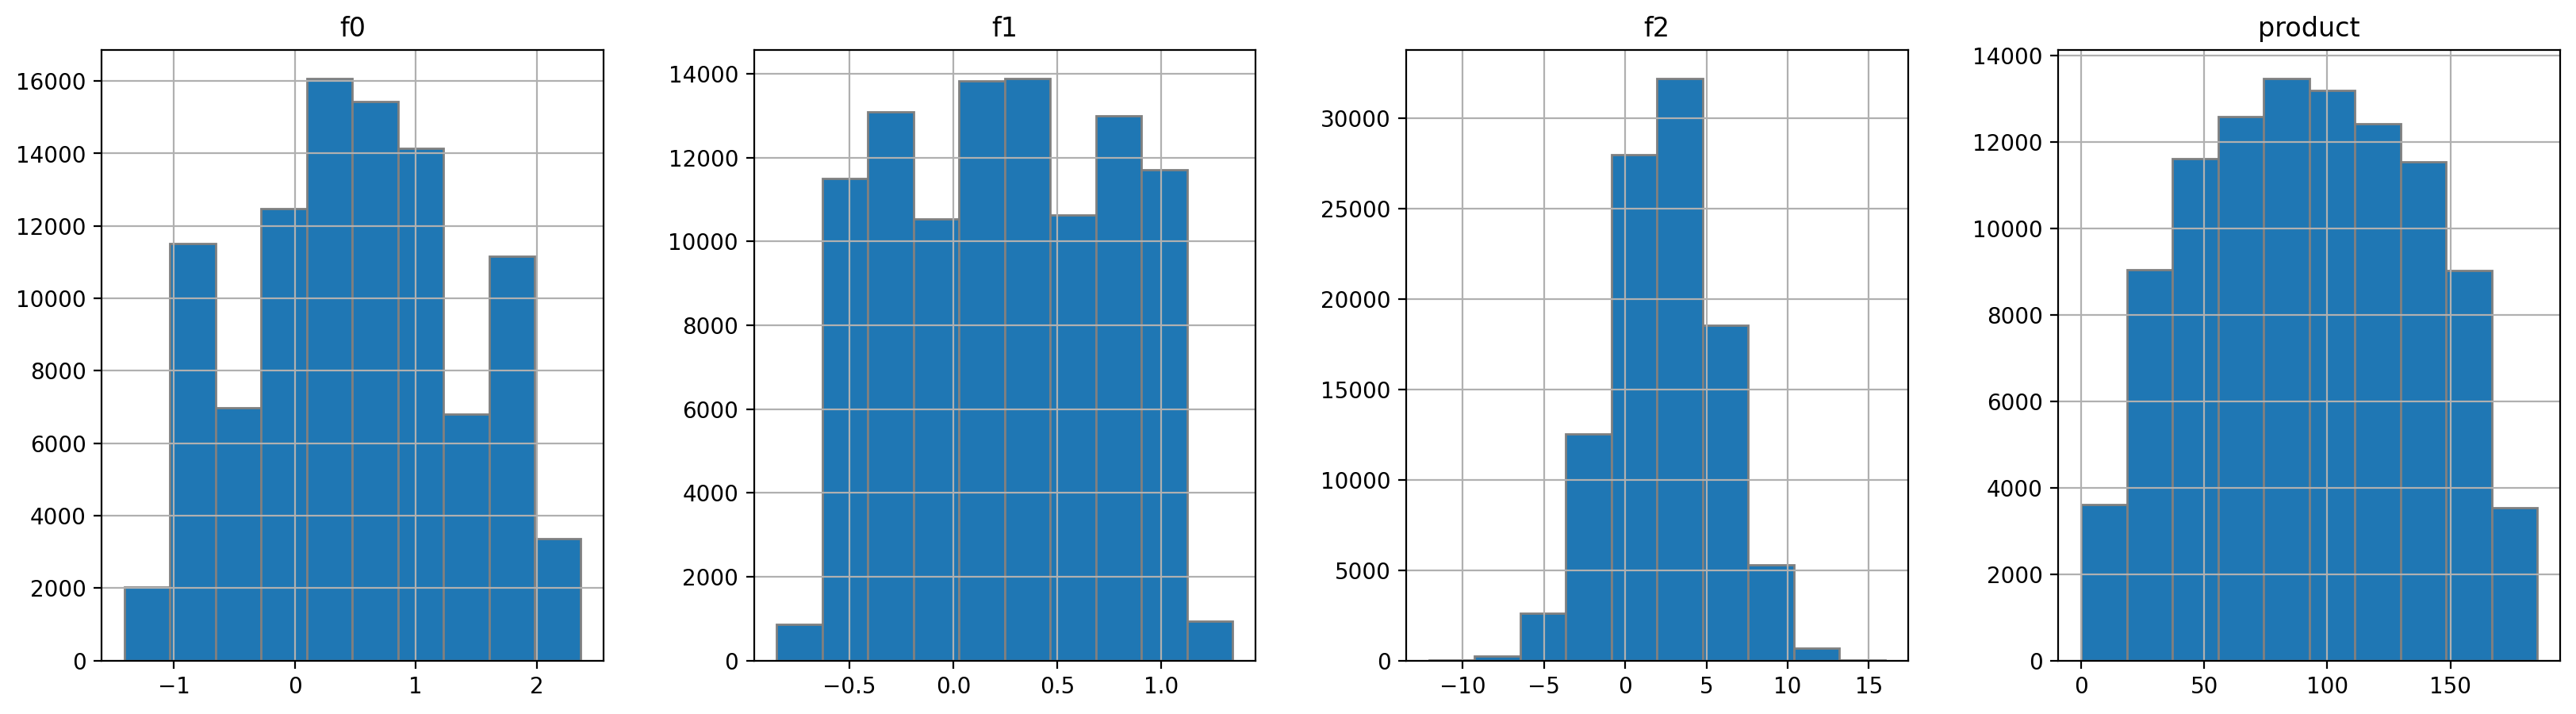

In [5]:
geo_0.info()
display(geo_0.describe())
display(geo_0.sample(5))
print()
print('Duplicates in geo_0 data: {0}'.format(geo_0.duplicated().sum()))
print()
print('Rows with duplicate ids:')
display(geo_0[geo_0.duplicated(['id'], keep=False)].sort_values(by='id'))
geo_0.hist(figsize=(20,5), edgecolor='gray', layout=(1,4));

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float32
 2   f1       100000 non-null  float32
 3   f2       100000 non-null  float32
 4   product  100000 non-null  float32
dtypes: float32(4), object(1)
memory usage: 2.3+ MB


,f0,f1,f2,product
count,100000.000,100000.000,100000.000,100000.000
mean,1.141,-4.797,2.495,68.825
std,8.966,5.120,1.704,45.944
min,-31.610,-26.359,-0.018,0.000
25%,-6.299,-8.268,1.000,26.953
50%,1.153,-4.813,2.011,57.086
75%,8.621,-1.333,4.000,107.813
max,29.422,18.734,5.020,137.945


,id,f0,f1,f2,product
94641,2lojN,10.664,2.468,5.000,134.766
17273,AAz5z,-8.996,4.070,1.993,57.086
84778,2eCns,-15.611,-0.881,0.000,3.179
19540,BXEXH,-12.573,-7.433,0.008,3.179
68714,NPwA6,5.381,-0.519,3.996,107.813



Duplicates in geo_0 data: 0

Rows with duplicate ids:


,id,f0,f1,f2,product
5849,5ltQ6,-3.435,-12.296,2.000,57.086
84461,5ltQ6,18.214,2.192,3.994,107.813
1305,LHZR0,11.171,-1.945,3.003,80.860
41906,LHZR0,-8.990,-4.287,2.009,57.086
2721,bfPNe,-9.494,-5.464,4.006,110.992
82178,bfPNe,-6.203,-4.820,2.995,84.039
47591,wt4Uk,-9.091,-8.109,-0.002,3.179
82873,wt4Uk,10.260,-9.376,4.994,134.766


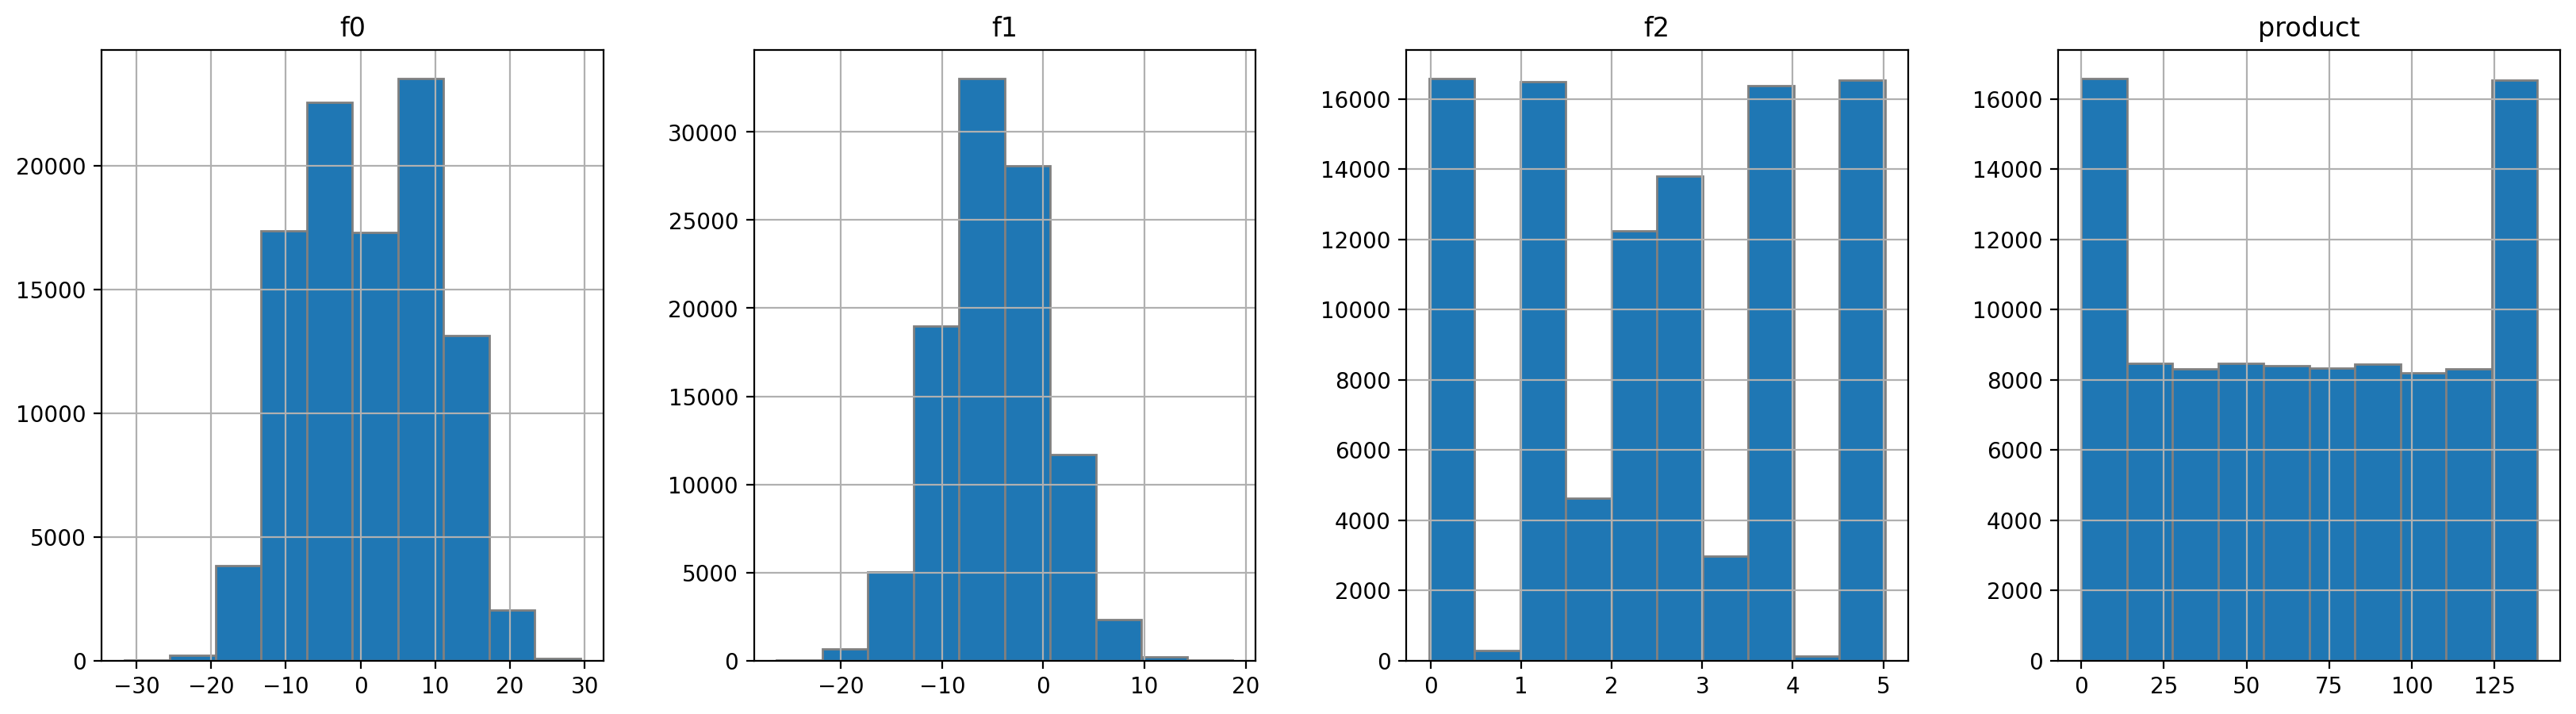

In [6]:
geo_1.info()
display(geo_1.describe())
display(geo_1.sample(5))
print()
print('Duplicates in geo_0 data: {0}'.format(geo_1.duplicated().sum()))
print()
print('Rows with duplicate ids:')
display(geo_1[geo_1.duplicated(['id'], keep=False)].sort_values(by='id'))
geo_1.hist(figsize=(20,5), edgecolor='gray', layout=(1,4));

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float32
 2   f1       100000 non-null  float32
 3   f2       100000 non-null  float32
 4   product  100000 non-null  float32
dtypes: float32(4), object(1)
memory usage: 2.3+ MB


,f0,f1,f2,product
count,100000.000,100000.000,100000.000,100000.000
mean,0.002,-0.002,2.495,95.000
std,1.732,1.730,3.473,44.750
min,-8.760,-7.084,-11.970,0.000
25%,-1.162,-1.175,0.130,59.450
50%,0.009,-0.009,2.484,94.926
75%,1.159,1.164,4.859,130.595
max,7.238,7.845,16.739,190.030


,id,f0,f1,f2,product
715,nlJ9W,0.203,-0.208,1.482,84.937
81019,vBdfW,0.783,-0.317,3.307,79.491
58628,kwN17,0.753,-2.180,8.108,176.518
99979,NIlG8,3.255,-0.643,-0.642,101.034
97345,p5dZj,1.289,1.571,-0.806,118.936



Duplicates in geo_0 data: 0

Rows with duplicate ids:


,id,f0,f1,f2,product
45404,KUPhW,0.232,-1.699,4.991,11.716
55967,KUPhW,1.211,3.176,5.544,132.832
11449,VF7Jo,2.123,-0.858,5.746,181.717
49564,VF7Jo,-0.883,0.561,0.724,136.233
44378,Vcm5J,-1.229,-2.439,1.223,137.968
95090,Vcm5J,2.588,1.987,2.482,92.328
28039,xCHr8,1.633,0.368,-2.378,6.121
43233,xCHr8,-0.847,2.102,5.597,184.389


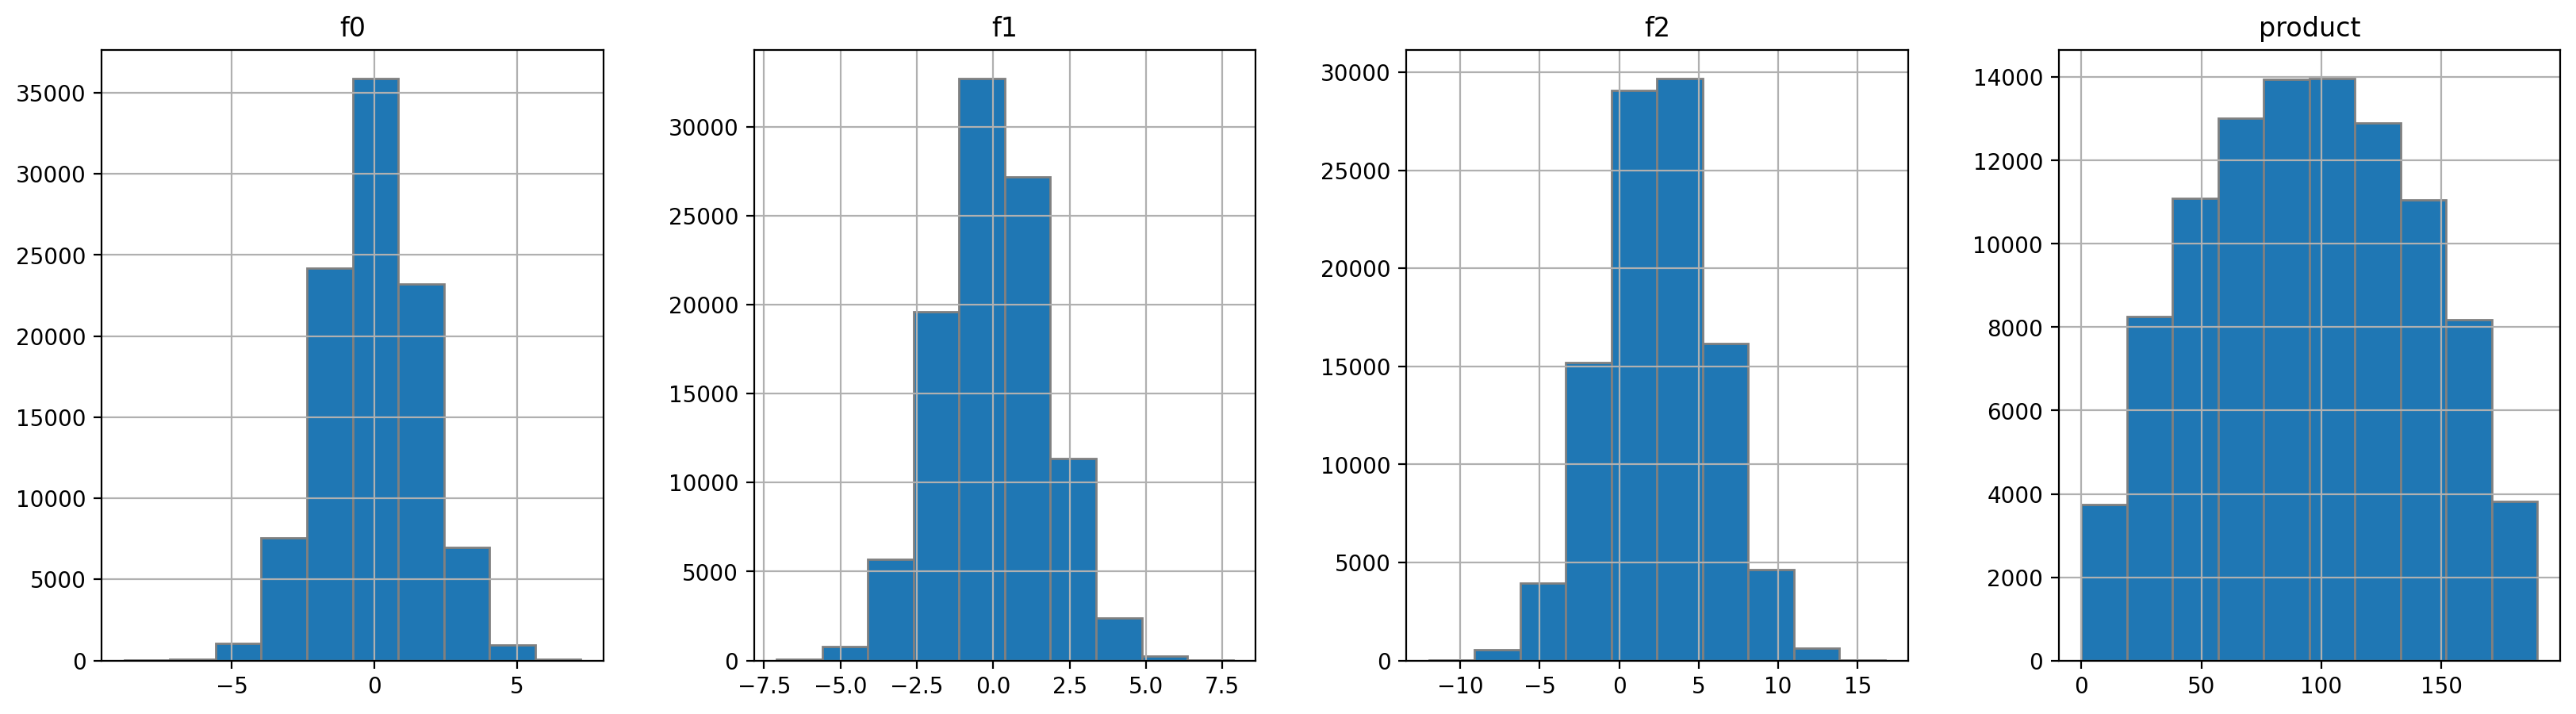

In [7]:
geo_2.info()
display(geo_2.describe())
display(geo_2.sample(5))
print()
print('Duplicates in geo_0 data: {0}'.format(geo_2.duplicated().sum()))
print()
print('Rows with duplicate ids:')
display(geo_2[geo_2.duplicated(['id'], keep=False)].sort_values(by='id'))
geo_2.hist(figsize=(20,5), edgecolor='gray', layout=(1,4));

In [8]:
geo_0.drop_duplicates(subset=['id'], keep=False, inplace=True)
geo_0.drop(['id'], axis=1, inplace = True)

geo_1.drop_duplicates(subset=['id'], keep=False, inplace=True)
geo_1.drop(['id'], axis=1, inplace = True)

geo_2.drop_duplicates(subset=['id'], keep=False, inplace=True)
geo_2.drop(['id'], axis=1, inplace = True)

**Conclusion**

There are no missing values in this dataset.

After the first investigation, we downcasted floats while reading from the file. 

We don't have any complete duplicates in this data set, but we have a small number of entries with duplicates in the `id` column for each region. We have no clue how this could happen and what entry to keep, so safer to drop both.
 
The `id` feature doesn't influence our target; thus, we could exclude it from the dataset.

## Train and test the model for each region

In [9]:
def model_region(df):
    X = df.drop(['product'], axis=1)
    y = df['product']

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)
    X_train = X_train.copy()
    X_val = X_val.copy()

    scaler = StandardScaler(copy=True)
    scaler.fit(X_train);
    X_train = scaler.transform(X_train);
    X_val = scaler.transform(X_val);

    print('Train set length:', X_train.shape[0])
    print('Validation set length:', X_val.shape[0])
    print()
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    predicted_val = model.predict(X_val)
    print(f'Average predicted volume: {predicted_val.mean():.3f}')        
    print(f'RMSE: {mean_squared_error(y_val, predicted_val) ** 0.5:.3f}')        
    
    return(y_val, pd.Series(predicted_val, index=y_val.index))

### Region 0

In [10]:
y_val_0, predicted_val_0 = model_region(geo_0)

Train set length: 74985
Validation set length: 24995

Average predicted volume: 92.287
RMSE: 37.761


### Region 1

In [11]:
y_val_1, predicted_val_1 = model_region(geo_1)

Train set length: 74994
Validation set length: 24998

Average predicted volume: 69.169
RMSE: 0.893


### Region 2

In [12]:
y_val_2, predicted_val_2 = model_region(geo_2)

Train set length: 74994
Validation set length: 24998

Average predicted volume: 94.821
RMSE: 40.131


**Conclusion**

We've built a Linear Regression model to predict the volume of reserves for the region.  
Regions 0 and 2 have an average predicted volume of 92-95 thousand barrels with an RMSE of 37-40, and region 1 nave an average predicted volume of 69 but a much smaller RMSE (0.1).

---

## Prepare for profit calculation

In [13]:
budget = 100_000_000
rev_by_unit = 4500
wells_number = 200

print(f'No loss volume of one well is larger than: {(budget/rev_by_unit)/wells_number:.3f}')

No loss volume of one well is larger than: 111.111


**Conclusion**

The volume of reserves sufficient for developing without losses is 111 for one well. It is larger than our average predicted volume, so let's calculate profit for a subset of best wells.

---

## Write a function to calculate profit from a set of selected oil wells and model predictions

In [14]:
best_size = 200

def profit(predictions, targets, best_size):
    indices = predictions.sort_values(ascending=False).iloc[:best_size].index
    profit = (targets[indices].sum()*rev_by_unit)-budget
    return profit
        

print(f'Profit of the whole region 0: {profit(predicted_val_0, y_val_0, best_size):.3f}')
print(f'Profit of the whole region 1: {profit(predicted_val_1, y_val_1, best_size):.3f}')
print(f'Profit of the whole region 2: {profit(predicted_val_2, y_val_2, best_size):.3f}')

Profit of the whole region 0: 33018215.820
Profit of the whole region 1: 24150886.719
Profit of the whole region 2: 21039145.508


**Conclusion**

Judging on the best wells for the whole region, our best candidate is region 0 with a predicted profit of 33 USD million.

---

## Calculate risks and profit for each region

In [15]:
state = np.random.RandomState(42)
sample_size = 500
alpha = 0.95

def bootstrap_profit(predictions, targets, sample_size):
    profits = []
    for i in range(1000):
        target_sample = targets.sample(n=sample_size, replace=True, random_state=state)
        predictions_sample = predictions[target_sample.index]
        profits.append(profit(predictions_sample.reset_index(drop=True), target_sample.reset_index(drop=True), best_size))
    profits = pd.Series(profits)    
    print(f'Profit mean: {profits.mean():.3f}')
    confidence_interval = st.t.interval(alpha, df=len(profits)-1, loc=profits.mean(), scale=profits.sem())        
    print(f'95% confidence interval: {confidence_interval}')
    loss_prob = len(profits[profits<0])/len(profits)
    print(f'Risk of losses: {loss_prob:.2%}')

print('Region 0:')
bootstrap_profit(predicted_val_0, y_val_0, sample_size)
print()
print('Region 1:')
bootstrap_profit(predicted_val_1, y_val_1, sample_size)
print()
print('Region 2:')
bootstrap_profit(predicted_val_2, y_val_2, sample_size)

Region 0:
Profit mean: 4057068.245
95% confidence interval: (3889748.454737412, 4224388.035496963)
Risk of losses: 7.20%

Region 1:
Profit mean: 4892177.700
95% confidence interval: (4759809.138573382, 5024546.261817243)
Risk of losses: 0.90%

Region 2:
Profit mean: 3588790.432
95% confidence interval: (3418782.369385898, 3758798.493895352)
Risk of losses: 9.60%


**Conclusion**

Using the bootstrapping technique, we estimated average profit, 95% confidence interval and risk of losses.  
We have one region with a risk of losses lower than 2.5%: region 1 (0.90%) and it's average profit is 4.9 USD million.

---

## Overall conclusion

Using some geological exploration data, we built a Linear Regression model to predict the volume of reserves for the region. Estimating the average profit from the 200 best wells for the region and the risk of losses, we could assume that the best place for new wells would be **Region 1**.